In [1]:
import mne
import mne_bids
from mne_bids import BIDSPath
import os, os.path as op
import nilearn
import matplotlib.pyplot as plt
import numpy as np

from nilearn import *

from nih2mne.utilities.bids_helpers import get_mri_dict
n_jobs = 10 #Number of parrallel operations

## Set some generic BIDS information

In [2]:
#Raw data
bids_root = op.join('/data/', os.environ['USER'], 'meg_workshop_data')  
#Processed Data Folder: contains (freesurfer / Day1 / Day2) 
deriv_root = op.join(bids_root, 'derivatives')  
#This course data - bids derivatives outputs for Day2 - hey thats today
project_root = op.join(deriv_root, 'Day2')  
#Freesurfer brain surface reconstruction
fs_subjects_dir = subjects_dir = op.join(deriv_root, 'freesurfer','subjects')

### Find data for a subject

In [3]:
subject = 'ON02811'
data_dict = get_mri_dict(subject,bids_root, task='airpuff')

# get_mri_dict is a helper function that provides all of the loaders for the mri integration
# Each dictionary item codes for the specific loader of that file - see use in next cell of code
data_dict

{'bem': <nih2mne.utilities.bids_helpers.data_getter at 0x1554be5a5190>,
 'fwd': <nih2mne.utilities.bids_helpers.data_getter at 0x1554c0cc0150>,
 'src': <nih2mne.utilities.bids_helpers.data_getter at 0x1554bdfb66d0>,
 'trans': <nih2mne.utilities.bids_helpers.data_getter at 0x1554be804dd0>}

#### Load the preprocessed data - Items from Lab3 MRI Processing

In [4]:
bem = data_dict['bem'].load()
fwd = data_dict['fwd'].load()
src = fwd['src']
trans = data_dict['trans'].load()

Loading surfaces...

Loading the solution matrix...

Homogeneous model surface loaded.
Loaded linear collocation BEM solution from /data/stoutjd/meg_workshop_data/derivatives/Day2/sub-ON02811/ses-01/meg/sub-ON02811_ses-01_task-airpuff_run-01_bem.fif
Reading forward solution from /data/stoutjd/meg_workshop_data/derivatives/Day2/sub-ON02811/ses-01/meg/sub-ON02811_ses-01_task-airpuff_run-01_fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 272 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


In [5]:
#Load the Raw data
bids_path = BIDSPath(root=bids_root, subject=subject, task='airpuff', run='01',session='01')
raw = mne.io.read_raw_ctf(bids_path.fpath, clean_names=True, preload=True, verbose=False)
raw.filter(0.3, 110, n_jobs=n_jobs)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 1.1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 110.00 Hz
- Upper transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 123.75 Hz)
- Filter length: 13201 samples (11.001 s)



[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done 186 tasks      | elapsed:    3.9s
[Parallel(n_jobs=10)]: Done 300 out of 300 | elapsed:    4.3s finished


<RawCTF | sub-ON02811_ses-01_task-airpuff_run-01_meg.meg4, 304 x 301200 (251.0 s), ~699.0 MB, data loaded>

### Prepare Imaging for Source Localization

In [6]:
evts, evtsid = mne.events_from_annotations(raw)

Used Annotations descriptions: ['missingstim', 'stim']


In [7]:
epochs = mne.Epochs(raw, evts, evtsid, tmin=-0.1, tmax=0.2, preload=True)

Not setting metadata
500 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 500 events and 361 original time points ...
0 bad epochs dropped


In [8]:
evk_stim = epochs['stim'].average()
evk_mssingstim = epochs['missingstim'].average()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.


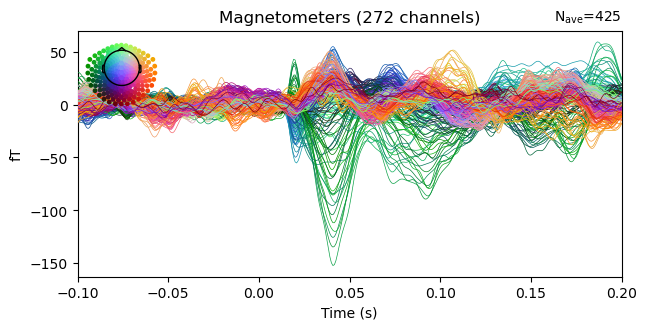

In [9]:
%matplotlib inline
_=evk_stim.plot()

## Multi-dipole (not available)

## MNE solution

In [10]:
cov = mne.compute_covariance(epochs['stim'], tmin=0, tmax = 0.1, method='shrunk', cv=5, n_jobs=n_jobs)

Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from data with rank=None
    Using tolerance 2.3e-08 (2.2e-16 eps * 272 dim * 3.8e+05  max singular value)
    Estimated rank (mag): 272
    MAG: rank 272 computed from 272 data channels with 0 projectors
Reducing data rank from 272 -> 272
Estimating covariance using SHRUNK
Done.
Number of samples used : 51425
[done]


In [11]:
evk_stim.crop(0.0,0.06)

<Evoked | 'stim' (average, N=425), 0 – 0.06 s, baseline -0.1 – 0 s (baseline period was cropped after baseline correction), 300 ch, ~559 kB>

Removing 5 compensators from info because not all compensation channels were picked.


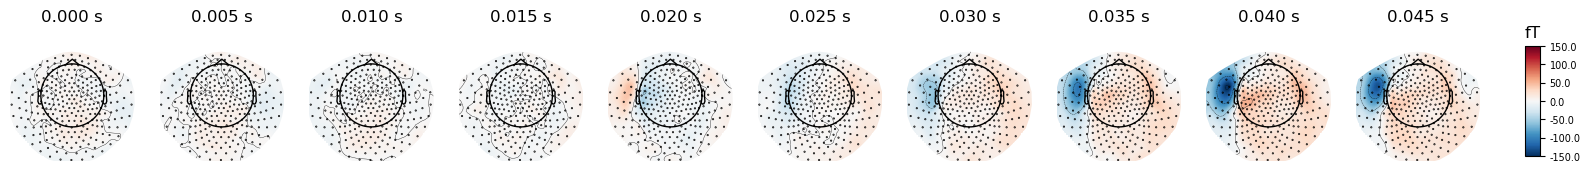

In [12]:
%matplotlib inline
_= evk_stim.plot_topomap(times=np.arange(0, 0.05, 0.005))

In [93]:
dip = mne.fit_dipole(evk_stim, cov, bem, trans=trans, n_jobs = n_jobs, rank='full')

BEM               : <ConductorModel | BEM (1 layer) solver=mne>
MRI transform     : instance of Transform
Head origin       :   -1.6    2.8   59.1 mm rad =   69.5 mm.
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using normal MEG coil definitions.
Noise covariance  : <Covariance | size : 272 x 272, n_samples : 51424, data : [[ 6.20174692e-27  4.46392795e-27  3.98998575e-27 ... -2.53509531e-27
  -2.35603373e-27 -1.00645772e-27]
 [ 4.46392795e-27  6.35650807e-27  6.01683192e-27 ... -1.72923058e-27
  -2.00278737e-27  1.82371522e-28]
 [ 3.98998575e-27  6.01683192e-27  9.55227597e-27 ... -1.28645638e-27
  -2.01738632e-27  8.21767879e-28]
 ...
 [-2.53509531e-27 -1.72923058e-27 -1.28645638e-27 ...  2.38196621e-26
   1.61374040e-26  1.24197629e-26]
 [-2.35603373e-27 -2.00278737e-27 -2.01738632e-27 ...  1.61374040e-26
   2.46936472e-26  4.11939360e-27]
 [-1.00645772e-27  1.82371522e-28  8.21767879e-28 ...  1.24197629e-26
   4.11939360e-27  1.84596866e

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


[done 150 sources]


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


---- Fitted :     0.0 ms, distance to inner skull : 4.9724 mm
---- Fitted :     1.7 ms, distance to inner skull : 4.9704 mm
---- Fitted :     3.3 ms, distance to inner skull : 5.0013 mm
---- Fitted :     4.2 ms, distance to inner skull : 5.0004 mm
---- Fitted :     2.5 ms, distance to inner skull : 7.7262 mm
---- Fitted :     7.5 ms, distance to inner skull : 10.3710 mm
---- Fitted :     0.8 ms, distance to inner skull : 5.0005 mm
---- Fitted :     5.8 ms, distance to inner skull : 4.2125 mm
---- Fitted :     8.3 ms, distance to inner skull : 11.6331 mm


[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    1.7s


---- Fitted :    10.8 ms, distance to inner skull : 9.7377 mm
---- Fitted :     6.7 ms, distance to inner skull : 4.9769 mm
---- Fitted :     9.2 ms, distance to inner skull : 4.9681 mm
---- Fitted :    12.5 ms, distance to inner skull : 5.0009 mm
---- Fitted :     5.0 ms, distance to inner skull : 5.0005 mm
---- Fitted :    11.7 ms, distance to inner skull : 7.6326 mm
---- Fitted :    13.3 ms, distance to inner skull : 5.0005 mm
---- Fitted :    15.0 ms, distance to inner skull : 15.2291 mm
---- Fitted :    10.0 ms, distance to inner skull : 7.4242 mm
---- Fitted :    14.2 ms, distance to inner skull : 4.9526 mm
---- Fitted :    15.8 ms, distance to inner skull : 17.3681 mm
---- Fitted :    16.7 ms, distance to inner skull : 16.5865 mm
---- Fitted :    18.3 ms, distance to inner skull : 13.9868 mm
---- Fitted :    20.8 ms, distance to inner skull : 10.7764 mm
---- Fitted :    21.7 ms, distance to inner skull : 10.0560 mm
---- Fitted :    19.2 ms, distance to inner skull : 12.6613 mm
-

[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    8.2s


---- Fitted :    50.8 ms, distance to inner skull : 11.1682 mm
---- Fitted :    53.3 ms, distance to inner skull : 29.9403 mm
---- Fitted :    55.0 ms, distance to inner skull : 29.8431 mm
---- Fitted :    55.8 ms, distance to inner skull : 29.4640 mm
---- Fitted :    54.2 ms, distance to inner skull : 29.9074 mm
---- Fitted :    50.0 ms, distance to inner skull : 12.9799 mm
---- Fitted :    56.7 ms, distance to inner skull : 26.0271 mm
---- Fitted :    57.5 ms, distance to inner skull : 4.9642 mm
---- Fitted :    58.3 ms, distance to inner skull : 4.9818 mm
---- Fitted :    59.2 ms, distance to inner skull : 5.0005 mm
---- Fitted :    60.0 ms, distance to inner skull : 5.0007 mm
No projector specified for this dataset. Please consider the method self.add_proj.
73 time points fitted


[Parallel(n_jobs=10)]: Done  73 out of  73 | elapsed:   10.4s finished


In [101]:
_ = dip[0].plot_locations(trans, 'sub-'+subject, fs_subjects_dir, mode='sphere', surf='pial')

In [98]:
tmp = dip[0]
tmp.plot_locations?

Signature:
tmp.plot_locations(
    trans,
    subject,
    subjects_dir=None,
    mode='orthoview',
    coord_frame='mri',
    idx='gof',
    show_all=True,
    ax=None,
    block=False,
    show=True,
    scale=None,
    color=None,
    *,
    highlight_color='r',
    fig=None,
    title=None,
    head_source='seghead',
    surf='pial',
    width=None,
    verbose=None,
)
Docstring:
Plot dipole locations.

If mode is set to 'arrow' or 'sphere', only the location of the first
time point of each dipole is shown else use the show_all parameter.

Parameters
----------
trans : dict | None
    The mri to head trans.
    Can be None with mode set to '3d'.
subject : str | None
    The FreeSurfer subject name (will be used to set the FreeSurfer
    environment variable ``SUBJECT``).
    Can be ``None`` with mode set to ``'3d'``.

subjects_dir : path-like | None
    The path to the directory containing the FreeSurfer subjects
    reconstructions. If ``None``, defaults to the ``SUBJECTS_DIR`` en

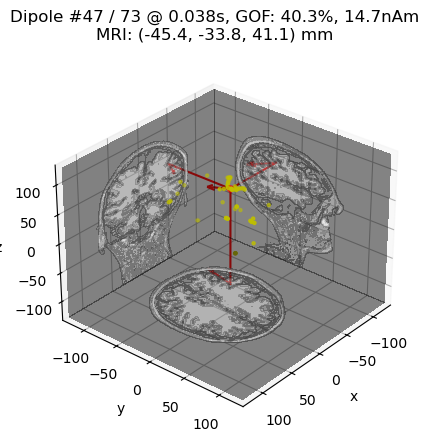

In [94]:
_ = dip[0].plot_locations(trans, 'sub-'+subject, fs_subjects_dir, mode="orthoview")

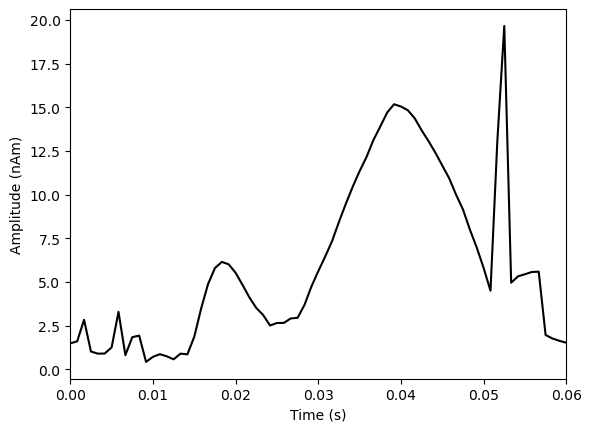

In [95]:
_=dip[0].plot_amplitudes()

# MNE solution

In [13]:
from mne.minimum_norm import apply_inverse, make_inverse_operator

In [14]:
# stc.plot?

## MNE solution is in current/Amps

In [24]:
inv = make_inverse_operator(evk_stim.info, fwd, cov, loose=0.0, depth=0.8, verbose=True)
snr = 3.0
lambda2 = 1.0 / snr**2
kwargs = dict(
    initial_time=0.04,
    hemi="lh",
    subjects_dir=subjects_dir,
    size=(600, 600),
    clim=dict(kind="values", lims=[6, 7.5, 10]),
    smoothing_steps=7,
    surface='white'
)

stc = abs(apply_inverse(evk_stim, inv, lambda2, "MNE", verbose=True))
brain = stc.plot(figure=1, **kwargs)
brain.add_text(0.1, 0.9, "dSPM", "title", font_size=14)

Computing inverse operator with 272 channels.
    272 out of 272 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 272 channels
Creating the depth weighting matrix...
    272 magnetometer or axial gradiometer channels
    limit = 8102/8196 = 10.047710
    scale = 2.41378e-11 exp = 0.8
    Picked elements from a free-orientation depth-weighting prior into the fixed-orientation one
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Whitening the forward solution.
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 1.7e-13 (2.2e-16 eps * 272 dim * 2.8  max singular value)
    Estimated rank (mag): 272
    MAG: rank 272 computed from 272 data channels with 0 projectors
    Setting small MAG eigenvalues to zero 

## dSPM solution is divided by projected noise -- This is a statistic

In [23]:
inv = make_inverse_operator(evk_stim.info, fwd, cov, loose=0.0, depth=0.8, verbose=True)
snr = 3.0
lambda2 = 1.0 / snr**2
kwargs = dict(
    initial_time=0.04,
    hemi="lh",
    subjects_dir=subjects_dir,
    size=(600, 600),
    clim=dict(kind="values", lims=[6, 7.5, 10]),
    smoothing_steps=7,
    surface='white'
)

stc = abs(apply_inverse(evk_stim, inv, lambda2, "dSPM", verbose=True))
brain = stc.plot(figure=1, **kwargs)
brain.add_text(0.1, 0.9, "dSPM", "title", font_size=14)

Computing inverse operator with 272 channels.
    272 out of 272 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 272 channels
Creating the depth weighting matrix...
    272 magnetometer or axial gradiometer channels
    limit = 8102/8196 = 10.047710
    scale = 2.41378e-11 exp = 0.8
    Picked elements from a free-orientation depth-weighting prior into the fixed-orientation one
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Whitening the forward solution.
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 1.7e-13 (2.2e-16 eps * 272 dim * 2.8  max singular value)
    Estimated rank (mag): 272
    MAG: rank 272 computed from 272 data channels with 0 projectors
    Setting small MAG eigenvalues to zero 

In [25]:
stc.save?

Signature: stc.save(fname, ftype='stc', *, overwrite=False, verbose=None)
Docstring:
Save the source estimates to a file.

Parameters
----------
fname : path-like
    The stem of the file name. The file names used for surface source
    spaces are obtained by adding ``"-lh.stc"`` and ``"-rh.stc"`` (or
    ``"-lh.w"`` and ``"-rh.w"``) to the stem provided, for the left and
    the right hemisphere, respectively.
ftype : str
    File format to use. Allowed values are ``"stc"`` (default),
    ``"w"``, and ``"h5"``. The ``"w"`` format only supports a single
    time point.

overwrite : bool
    If True (default False), overwrite the destination file if it
    exists.

    .. versionadded:: 1.0

verbose : bool | str | int | None
    Control verbosity of the logging output. If ``None``, use the default
    verbosity level. See the :ref:`logging documentation <tut-logging>` and
    :func:`mne.verbose` for details. Should only be passed as a keyword
    argument.
File:      /data/MEGmodules/mo

## Beamformer Solution

In [42]:
import pylab

In [43]:
pylab.plot(dipevk.times, dipevk.get_data())

<IPython.core.display.Javascript object>

ValueError: x and y must have same first dimension, but have shapes (121,) and (300, 121)